In [4]:
import datetime
from pathlib import Path
import time

import numpy as np

from timor.Geometry import Box, ComposedGeometry, Cylinder
from timor.Module import ModuleAssembly, ModulesDB
from timor.Robot import PinRobot
from timor.task import CostFunctions, Solution, Tolerance
from timor.task.Goals import Reach
from timor.task.Obstacle import Obstacle
from timor.task.Task import Task, TaskHeader
from timor.utilities.trajectory import Trajectory
from timor.utilities.file_locations import robots as robot_data
from timor.utilities.file_locations import get_module_db_files
import timor.utilities.logging as logging
from timor.utilities.transformation import Transformation
from timor.utilities.tolerated_pose import ToleratedPose
from timor.utilities.spatial import rotX, rotY, rotZ

In [5]:
# Create a task
header = TaskHeader(
    ID='Pick & Place',
    tags=['IROS2023', 'demo'],
    date=datetime.datetime(2022, 9, 15),
    author=['Jonathan Külz'],
    email=['jonathan.kuelz@tum.de'],
    affiliation=['Technical University of Munich']
)

# Create a table and a plateau, the obstacles to deal with
height = .4
plateau_height = .04
r_leg = 0.05
dx = 1.6
dy = .8
dz = .05

plateau_placement = Transformation.from_translation([.3 * dx, .2 * dy, height + dz/2 + plateau_height / 2])

surface = Box(dict(x=dx, y=dy, z=dz), pose=Transformation.from_translation([0, 0, height]))
legs = [
    Cylinder(dict(r=r_leg, z=height),
             pose=Transformation.from_translation([i * (dx / 2 - r_leg), j * (dy / 2 - r_leg), height / 2]))
    for i, j in ((-1, -1), (-1, 1), (1, -1), (1, 1))
]
table = Obstacle(ID='table', collision=ComposedGeometry([surface] + legs))
plateau = Obstacle(ID='plateau',
                   collision=Box(dict(x=.3, y=.2, z=plateau_height), pose=plateau_placement))

# Define the goals slightly above the table and the plateau - here would be the grapsing points
first_goal = Reach(ID='Reach One',
                   goalPose=ToleratedPose(nominal=Transformation.from_translation([.55, .2, height + dz + plateau_height]) @ rotX(np.pi),
                                           tolerance=Tolerance.CartesianSpheric.default()))
second_goal = Reach(ID='Reach Two',
                    goalPose=ToleratedPose(nominal=Transformation.from_translation([-.55, .2, height + dz]) @ rotX(np.pi),
                                            tolerance=Tolerance.CartesianSpheric.default()))

task = Task(header, obstacles=[plateau, table], goals=[first_goal, second_goal])

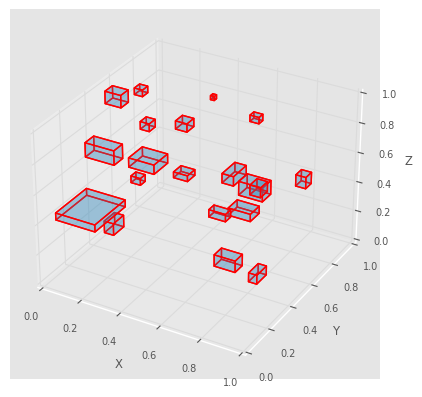

[{'size': {'x': 0.019188174684252043, 'y': 0.021416007990199815, 'z': 0.02681917564321015}, 'origin': {'x': 0.33093713255567236, 'y': 0.8890578399854246, 'z': 0.7946120970568225}}, {'size': {'x': 0.2, 'y': 0.2445738426489472, 'z': 0.04612891186855401}, 'origin': {'x': 0.0574342679341787, 'y': 0.02610601324844564, 'z': 0.438980259206318}}, {'size': {'x': 0.04448548403102411, 'y': 0.03465061001970749, 'z': 0.04135170274955904}, 'origin': {'x': 0.6599876483303381, 'y': 0.656760694063845, 'z': 0.9059403821744587}}, {'size': {'x': 0.04837144111046056, 'y': 0.08641210857522631, 'z': 0.08028853941210683}, 'origin': {'x': 0.076379130228653, 'y': 0.37666873575072957, 'z': 0.11627533207906121}}, {'size': {'x': 0.048604807641181816, 'y': 0.041198839781649, 'z': 0.045253747253718404}, 'origin': {'x': 0.1841346397743923, 'y': 0.43798878788006723, 'z': 0.46227963650155013}}, {'size': {'x': 0.05965179317871407, 'y': 0.12023421451138183, 'z': 0.06503586040201839}, 'origin': {'x': 0.43037288700609805, 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Function to generate cuboid vertices
def cuboid_data(origin, size):
    """ Create cuboid vertices based on the origin and size. """
    x = [origin[0], origin[0] + size[0]]
    y = [origin[1], origin[1] + size[1]]
    z = [origin[2], origin[2] + size[2]]
    return np.array([[x[0], y[0], z[0]],
                     [x[1], y[0], z[0]],
                     [x[1], y[1], z[0]],
                     [x[0], y[1], z[0]],
                     [x[0], y[0], z[1]],
                     [x[1], y[0], z[1]],
                     [x[1], y[1], z[1]],
                     [x[0], y[1], z[1]]])

# Function to plot cuboid
def plot_cuboid(ax, cuboid):
    """ Plot cuboid using its vertices. """
    vertices = [[cuboid[0], cuboid[1], cuboid[2], cuboid[3]],
                [cuboid[4], cuboid[5], cuboid[6], cuboid[7]],
                [cuboid[0], cuboid[1], cuboid[5], cuboid[4]],
                [cuboid[2], cuboid[3], cuboid[7], cuboid[6]],
                [cuboid[1], cuboid[2], cuboid[6], cuboid[5]],
                [cuboid[4], cuboid[7], cuboid[3], cuboid[0]]]

    faces = Poly3DCollection(vertices, linewidths=1, edgecolors='r', alpha=.25)
    ax.add_collection3d(faces)

# Function to check for overlap between two cuboids using their axis-aligned bounding boxes (AABB)
def check_overlap(cub1_min, cub1_max, cub2_min, cub2_max):
    """ Check if two cuboids overlap based on their AABBs (axis-aligned bounding boxes). """
    return not (cub1_max[0] <= cub2_min[0] or cub1_min[0] >= cub2_max[0] or
                cub1_max[1] <= cub2_min[1] or cub1_min[1] >= cub2_max[1] or
                cub1_max[2] <= cub2_min[2] or cub1_min[2] >= cub2_max[2])

# Random cuboid volume generation
def random_cuboid_volume(total_volume, num_cuboids):
    volumes = np.random.rand(num_cuboids)
    volumes = volumes / np.sum(volumes) * total_volume
    return volumes

# Function to generate cuboid size, ensuring it fits within the space and respects a maximum size
def generate_random_cuboid(vol, max_size, space_size=(1.0, 1.0, 1.0)):
    """ Generates random cuboid dimensions, ensuring that no dimension exceeds the maximum size. """
    dims = np.random.rand(3)
    dims = dims / np.prod(dims) * vol  # Ensure the product equals the cuboid volume
    dims = np.cbrt(dims)               # Adjust dimensions to ensure valid scaling
    dims = np.minimum(dims, max_size)  # Apply maximum size constraint to each dimension
    dims = np.minimum(dims, space_size)  # Ensure dimensions fit within the space
    return dims

# Plot cuboids and ensure no overlap
def plot_random_cuboids(num_cuboids=20, total_volume=0.001, space_size=(1.0, 1.0, 1.0), max_size=(0.5, 0.5, 0.5)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    cuboids = []
    volumes = random_cuboid_volume(total_volume, num_cuboids)
    attempts = 0

    # List to store sizes and origins
    cuboid_info = []

    while len(cuboids) < num_cuboids and attempts < 10000:
        vol = volumes[len(cuboids)]
        dims = generate_random_cuboid(vol, max_size, space_size)

        # Generate random position ensuring the cuboid is within space boundaries
        origin = np.random.rand(3) * (np.array(space_size) - dims)

        # Calculate min and max corners for the AABB
        cub_min = origin
        cub_max = origin + dims

        # Check for overlap with all previously placed cuboids
        if all(not check_overlap(cub_min, cub_max, cub[0], cub[1]) for cub in cuboids):
            cuboids.append((cub_min, cub_max))
            cuboid = cuboid_data(cub_min, dims)
            plot_cuboid(ax, cuboid)
            # Store size and origin in the desired format
            cuboid_info.append({
                'size': {'x': float(dims[0]), 'y': float(dims[1]), 'z': float(dims[2])},
                'origin': {'x': float(origin[0]), 'y': float(origin[1]), 'z': float(origin[2])}
            })
        attempts += 1
        if attempts >= 10000:
            print("Maximum number of attempts reached. Could not place all cuboids without overlap.")
            break

    # Set axis labels and limits
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim([0, space_size[0]])
    ax.set_ylim([0, space_size[1]])
    ax.set_zlim([0, space_size[2]])
    plt.show()

    return cuboid_info

# Plot the cuboids with a maximum size of 0.2 in x, 0.3 in y, and 0.2 in z dimensions
cuboid_data_list = plot_random_cuboids(max_size=(0.2, 0.3, 0.2))

# Print the sizes and origins
print(cuboid_data_list)


In [7]:
header = TaskHeader(
    ID='Random Obstacles Generation',
    tags=['Capstone', 'demo'],
    date=datetime.datetime(2024, 10, 28),
    author=['Jonas Li'],
    email=['liyunzhe.jonas@berkeley.edu'],
    affiliation=['UC Berkeley']
)

box = []
for idx, info in enumerate(cuboid_data_list):
    size, displacement = info["size"], info["origin"]
    box.append(Obstacle(ID=str(idx), 
                 collision=Box(
                     dict(x=size['x'], y=size['y'], z=size['z']),  # Size
                     pose=Transformation.from_translation([displacement['x'], displacement['y'], displacement['z']])
                          @ Transformation.from_rotation(rotY(np.pi / 2)[:3, :3]))))# Displacement
print(len(box))
task = Task(header, obstacles=[i for i in box])

20


In [8]:
task.visualize()

2024-10-30 01:43:52,782 Timor INFO Cannot recenter visualizer view to base.


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
